In [1]:
# # prompt: get the drive connected to the notebook

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
!pip install torch torch_geometric transformers matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   --------- ------------------------------ 1.8/8.0 MB 10.1 MB/s eta 0:00:01
   ------------------- -------------------- 3.9/8.0 MB 9.8 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.0 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 9.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------------- ------ 1.8/2.2 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 8.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Danilka\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Should return the CUDA version if available
print(torch.backends.cudnn.enabled)  # Should be True if CUDA is properly configured


C:\Users\Danilka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu116
11.6
True


if cuda version none - install pytorch with cuda

In [5]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Danilka\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


GPU is available. Using: NVIDIA GeForce RTX 3090


In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [14]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


In [10]:
import os
import json
import torch
from torch_geometric.data import Data

def preprocess_object(obj, tokenizer=tokenizer, device=device):
    # Extract graph data
    vertices = torch.tensor(obj['v'], dtype=torch.float).to(device)  # Move to device
    edges = torch.tensor(obj['e'], dtype=torch.long).t().to(device)  # Transpose and move to device

    # Encode text label using BERT
    text_label_str = obj['n']
    inputs = tokenizer(text_label_str, return_tensors="pt", padding=True, truncation=True, max_length=32)
    input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

    with torch.no_grad():
        outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
    text_label_embedding = outputs.last_hidden_state.to(device)  # Pool the embeddings and move to device
    print(text_label_embedding.shape)
    pooled_text_label = text_label_embedding.mean(dim=1)
    # Create graph data
    graph_data = Data(x=vertices, edge_index=edges, text_label=pooled_text_label)
    
    print(graph_data)
    return graph_data

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

        return preprocess_object(data)

def create_dataset(folder_path):
    dataset = []
    file_list = os.listdir(folder_path)
    print(len(file_list))
    for file_name in file_list:
        if file_name.endswith('.json'):
            file_path = os.path.join(folder_path, file_name)
            data = load_json(file_path)
            dataset.append(data)
            print(file_name)
    return dataset

In [11]:
# Dataset and DataLoader
def load_data_and_split(folder_path, ):
    dataset = create_dataset(folder_path)
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [15]:
train_dataset, val_dataset, test_dataset = load_data_and_split('./sample')

90
torch.Size([1, 3, 768])
Data(x=[2985, 3], edge_index=[2, 4646], text_label=[1, 768])
10155655850468db78d106ce0a280f87.json
torch.Size([1, 3, 768])
Data(x=[1432, 3], edge_index=[2, 3824], text_label=[1, 768])
1021a0914a7207aff927ed529ad90a11.json
torch.Size([1, 3, 768])
Data(x=[1984, 3], edge_index=[2, 4938], text_label=[1, 768])
1026dd1b26120799107f68a9cb8e3c.json
torch.Size([1, 3, 768])
Data(x=[4206, 3], edge_index=[2, 7780], text_label=[1, 768])
103c9e43cdf6501c62b600da24e0965.json
torch.Size([1, 3, 768])
Data(x=[3415, 3], edge_index=[2, 6304], text_label=[1, 768])
105f7f51e4140ee4b6b87e72ead132ed.json
torch.Size([1, 3, 768])
Data(x=[2658, 3], edge_index=[2, 5640], text_label=[1, 768])
1066b65c30d153e04c3a35cee92bb95b.json
torch.Size([1, 3, 768])
Data(x=[3575, 3], edge_index=[2, 6435], text_label=[1, 768])
106dfe858cb8fbc2afc6b80d80a265ab.json
torch.Size([1, 3, 768])
Data(x=[1969, 3], edge_index=[2, 3484], text_label=[1, 768])
10aa040f470500c6a66ef8df4909ded9.json
torch.Size([1, 3

Vertices: [[-1.000e-04  1.020e-02  4.680e-02]
 [-1.000e-04  1.009e-01  4.920e-02]
 [-6.400e-03  1.470e-02  4.680e-02]
 ...
 [-2.290e-02 -3.040e-02 -4.500e-02]
 [-2.050e-02 -1.772e-01 -9.000e-04]
 [-3.890e-02 -1.333e-01 -9.000e-04]]
Edges: [[   0    0    1 ... 1954 1957 1960]
 [   2    1    2 ... 1960 1961 1961]]
Text: [[ 1.22907639e-01  3.16366367e-02 -2.28111863e-01  8.25572163e-02
   4.32494804e-02 -3.63101959e-01  3.12405467e-01 -7.15669841e-02
   8.40894282e-02 -3.35004985e-01 -1.37136042e-01  5.17564230e-02
  -1.20894304e-02 -6.91571534e-02 -2.86983073e-01 -2.12569922e-01
  -9.78329331e-02  1.90380201e-01  1.68126702e-01  1.69590876e-01
   1.43836409e-01 -6.01608232e-02  2.68077821e-01  6.13650195e-02
   1.00531936e-01  2.42269322e-01 -9.09413844e-02 -2.21293435e-01
  -4.49494123e-01  1.94326684e-01 -1.46332085e-01 -1.71529740e-01
   7.40928799e-02  4.81292009e-01 -1.19563065e-01 -2.08144844e-01
   9.44178626e-02 -6.62658215e-02 -2.00008631e-01 -1.01776682e-01
  -3.46620083e-02  6

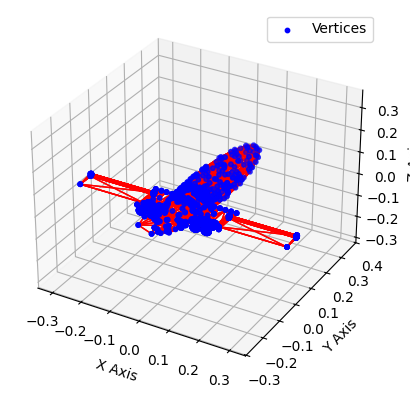

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize the 3D graph
def visualize_3d(vertices, edges):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure vertices are a numpy array
    vertices = np.array(vertices)

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]  # Each column represents an edge (start_index, end_index)
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]], c='r', linewidth=1)

    # Set plot labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    # Set equal scaling for all axes
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Display the plot
    plt.show()

# Extract vertices and edges from the dataset
vertices_np, edges_np, text_label = train_dataset[1].x.cpu().numpy(), train_dataset[1].edge_index.cpu().numpy(),train_dataset[1].text_label.cpu().numpy()

# Print the first graph's data for verification
print("Vertices:", vertices_np)
print("Edges:", edges_np)
print("Text:", text_label)

# Visualize the first graph
visualize_3d(vertices_np, edges_np)


In [20]:
import torch.nn as nn

class NodeCountPredictor(nn.Module):
    def __init__(self, latent_dim):
        super(NodeCountPredictor, self).__init__()
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Predict a single scalar
        )

    def forward(self, z):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            predicted_node_count: Scalar prediction for the number of nodes
        """
        return self.node_count_predictor(z).squeeze(-1)

def pretrain_node_count_predictor(predictor, data_loader, optimizer, device, num_epochs=10):
    predictor.train()
    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            z = data.latent_vector  # Use precomputed latent vector
            true_num_nodes = data.num_nodes  # Ground truth node count
            
            # Forward pass
            predicted_num_nodes = predictor(z)
            
            # Compute loss
            loss = loss_fn(predicted_num_nodes, true_num_nodes.float())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(data_loader):.4f}")


# NodeCountPredictor()
# pretrain_node_count_predictor()

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# Transformer Encoder
class TransformerTextEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerTextEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )

    def forward(self, text_input):
        """
        Args:
            text_input: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            encoded_text: Tensor of shape [batch_size, seq_len, embed_dim]
        """
        # Transpose to match Transformer input format: [seq_len, batch_size, embed_dim]
        text_input = text_input.permute(1, 0, 2)

        # Encode text
        encoded_text = self.transformer(text_input)  # Shape: [seq_len, batch_size, embed_dim]

        # Transpose back to [batch_size, seq_len, embed_dim]
        return encoded_text.permute(1, 0, 2)


# Graph Encoder (GNN)
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        return x.mean(dim=0)  # Pooling to get latent feature z_G

# Feature Fusion
class FeatureFusion(nn.Module):
    def __init__(self, text_dim, graph_dim, fused_dim):
        super(FeatureFusion, self).__init__()
        self.fc = nn.Linear(text_dim + graph_dim, fused_dim)

    def forward(self, c_text, z_G):
        """
        Args:
            c_text: Encoded text from the Transformer [batch_size, seq_len, embed_dim]
            z_G: Encoded graph representation [batch_size, graph_dim]
        Returns:
            fused_features: Combined features [batch_size, fused_dim]
        """

        # Pool the sequence dimension of c_text
        c_text_pooled = c_text.mean(dim=1)  # Shape: [batch_size, text_dim]

        # Match dimensions of c_text and z_G
        if c_text_pooled.ndim == 2 and z_G.ndim == 1:
            z_G = z_G.unsqueeze(0).expand(c_text_pooled.size(0), -1)

        # Concatenate features and pass through the fully connected layer
        combined_features = torch.cat([c_text_pooled, z_G], dim=-1)  # Shape: [batch_size, text_dim + graph_dim]
        fused_features = self.fc(combined_features)  # Shape: [batch_size, fused_dim]
        return fused_features


# Vector Quantization (VQ)
class VectorQuantization(nn.Module):
    def __init__(self, codebook_size, embedding_dim):
        super(VectorQuantization, self).__init__()
        self.codebook = nn.Embedding(codebook_size, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

    def forward(self, z):
        z_flattened = z.view(-1, z.size(-1))
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     - 2 * torch.matmul(z_flattened, self.codebook.weight.T)
                     + torch.sum(self.codebook.weight**2, dim=1))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(encoding_indices).view(z.shape)
        return z_q, encoding_indices


In [22]:
class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, node_dim):
        super(GraphDecoder, self).__init__()
        self.node_decoder = nn.Linear(latent_dim, node_dim)
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 1),
            nn.ReLU()  # Ensure non-negative outputs
        )
        self.node_count_predictor[0].weight.data.uniform_(0.1, 1.0)
        self.node_count_predictor[0].bias.data.fill_(10)  # Initialize bias to a higher value


    def forward(self, z,true_num_nodes=1):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            reconstructed_nodes: Tensor of shape [num_predicted_nodes, node_dim]
            reconstructed_adj: Tensor of shape [num_predicted_nodes, num_predicted_nodes]
        """
        batch_size = z.size(0)
        assert batch_size == 1, "Currently, this decoder supports only batch_size=1."

        # Predict the number of nodes
        raw_node_counts = self.node_count_predictor(z).squeeze(-1)  # Shape: [batch_size]
        predicted_num_nodes = torch.clamp(raw_node_counts.round(), min=50, max=10000).long().item()  # Scalar: num_nodes

        # Expand latent vector for node decoding
        if(true_num_nodes==1):
            z_expanded = z.expand(predicted_num_nodes, -1)  # [predicted_num_nodes, latent_dim]
        else:
            z_expanded = z.expand(true_num_nodes, -1)  # [predicted_num_nodes, latent_dim]

        # Decode nodes
        reconstructed_nodes = self.node_decoder(z_expanded)  # [predicted_num_nodes, node_dim]

        # Decode adjacency matrix using pairwise similarity
        reconstructed_adj = torch.sigmoid(torch.matmul(z_expanded, z_expanded.T))  # [predicted_num_nodes, predicted_num_nodes]

        return reconstructed_nodes, reconstructed_adj


In [23]:
class TransformerGraphDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, vocab_size):
        super(TransformerGraphDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 100, embed_dim))  # Adjust max sequence length
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt, memory):
        """
        Args:
            tgt: Target sequence [batch_size, seq_len]
            memory: Encoded memory from the Transformer Encoder [batch_size, seq_len, embed_dim]

        Returns:
            Output logits for graph tokens [batch_size, seq_len, vocab_size]
        """
        tgt_embedded = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.decoder(tgt_embedded.transpose(0, 1), memory.transpose(0, 1), tgt_mask).transpose(0, 1)
        logits = self.fc_out(output)
        return logits

In [25]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from torch.optim import Adam

def set_mode(model, mode="train"):
    """
    Set all components of the model to train or eval mode.
    Args:
        model (dict): Dictionary of model components.
        mode (str): "train" or "eval".
    """
    for component in model.values():
        if mode == "train":
            component.train()
        elif mode == "eval":
            component.eval()

# Training Function
def pad_tensor(tensor, target_shape, padding_value=0.0):
    """
    Pads or truncates a tensor to the target shape.
    Args:
        tensor (torch.Tensor): Input tensor.
        target_shape (tuple): Desired shape after padding.
        padding_value (float): Value for padding.
    Returns:
        torch.Tensor: Padded/truncated tensor.
    """
    padded_tensor = torch.full(target_shape, padding_value, device=tensor.device, dtype=tensor.dtype)

    # Calculate slices for assignment
    slices = tuple(slice(0, min(s, t)) for s, t in zip(tensor.shape, target_shape))
    padded_tensor[slices] = tensor[slices]
    return padded_tensor

def compute_node_count_loss(predicted_num_nodes, true_num_nodes):
    """
    Args:
        predicted_num_nodes: Scalar - Number of nodes predicted by the model.
        true_num_nodes: Scalar - Ground truth number of nodes.
    Returns:
        node_count_loss: Loss for node count prediction.
    """
    return F.mse_loss(predicted_num_nodes.float(), true_num_nodes.float())
def compute_loss(reconstructed_nodes, ground_truth_nodes, reconstructed_adj, ground_truth_adj, true_num_nodes, predicted_num_nodes):
    """
    Args:
        reconstructed_nodes: Predicted node features [num_predicted_nodes, node_dim].
        ground_truth_nodes: Ground truth node features [num_true_nodes, node_dim].
        reconstructed_adj: Predicted adjacency matrix [num_predicted_nodes, num_predicted_nodes].
        ground_truth_adj: Ground truth adjacency matrix [num_true_nodes, num_true_nodes].
        true_num_nodes: Scalar - Number of nodes in the ground truth graph.
        predicted_num_nodes: Scalar - Number of nodes predicted by the model.
    Returns:
        loss: Total reconstruction loss (nodes + adjacency).
    """
    # Determine the max size for alignment
    max_nodes = max(true_num_nodes, predicted_num_nodes)

    # Pad predicted outputs
    reconstructed_nodes_padded = pad_tensor(reconstructed_nodes, (max_nodes, ground_truth_nodes.size(-1)))
    reconstructed_adj_padded = pad_tensor(reconstructed_adj, (max_nodes, max_nodes))

    # Pad ground truth
    ground_truth_nodes_padded = pad_tensor(ground_truth_nodes, (max_nodes, ground_truth_nodes.size(-1)))
    ground_truth_adj_padded = pad_tensor(ground_truth_adj, (max_nodes, max_nodes))

    # Create a mask for valid nodes
    mask = torch.arange(max_nodes, device=ground_truth_nodes.device) < true_num_nodes

    # Node reconstruction loss
    loss_nodes = F.mse_loss(
        reconstructed_nodes_padded[mask],
        ground_truth_nodes_padded[mask]
    )

    # Adjacency reconstruction loss
    adj_mask = mask.unsqueeze(1) & mask.unsqueeze(0)
    loss_adj = F.mse_loss(
        reconstructed_adj_padded[adj_mask],
        ground_truth_adj_padded[adj_mask]
    )

    return loss_nodes + loss_adj


def train_one_epoch(model, data_loader, optimizer, device,epoch):
    set_mode(model, mode="train")
    total_loss = 0
    max_nodes = 6000  # Define the maximum number of nodes for padding
    print("Training", len(data_loader))
    
    for data in data_loader:
        data = data.to(device)

        # Inputs
        text_input = data.text_label  # Use the text_label from the data
        graph_x = data.x  # Node features
        edge_index = data.edge_index  # Edge indices

        # Forward pass
        c_text = model['text_encoder'](text_input.unsqueeze(1))  # Encode text
        z_G = model['graph_encoder'](graph_x, edge_index)  # Encode graph
        
        fused_features = model['feature_fusion'](c_text, z_G)  # Fuse features
        z_qG, _ = model['vector_quantizer'](fused_features)  # Quantize
        
        if(epoch<25):
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,graph_x.size(0))  # Decode
        else:
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,1)  # Decode

        
        
        # Ground truth adjacency matrix (dense)
        target_adj = to_dense_adj(edge_index).squeeze(0)
        
# Predict number of nodes
        predicted_num_nodes = reconstructed_nodes.size(0)

# Compute node count loss
        node_count_loss = compute_node_count_loss(
            torch.tensor(predicted_num_nodes, device=device),  # Convert scalar to tensor
            torch.tensor(graph_x.size(0), device=device)
        )

# Combine with reconstruction loss
        reconstruction_loss = compute_loss(
            reconstructed_nodes,
            graph_x,
            reconstructed_adj,
            target_adj,
            graph_x.size(0),
            predicted_num_nodes
        )
        loss = reconstruction_loss   # Add node count loss with a weight

        # G
        # loss_nodes = F.mse_loss(reconstructed_nodes_padded, graph_x_padded)
        # loss_adj = F.mse_loss(reconstructed_adj_padded, target_adj_padded)
        # loss = loss_nodes + loss_adj

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate(model, data_loader, device):
    set_mode(model, mode="eval")
    total_loss = 0

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)

            # Inputs
            text_input = data.text_label  # Use the text_label from the data
            graph_x = data.x  # Node features
            edge_index = data.edge_index  # Edge indices

            # Forward pass
            c_text = model['text_encoder'](text_input.unsqueeze(1))  # Encode text
            z_G = model['graph_encoder'](graph_x, edge_index)  # Encode graph
            
            fused_features = model['feature_fusion'](c_text, z_G)  # Fuse features
            z_qG, _ = model['vector_quantizer'](fused_features)  # Quantize
            reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG,graph_x.size(0))  # Decode

            # Ground truth adjacency matrix (dense)
            target_adj = to_dense_adj(edge_index).squeeze(0)

            # Compute loss
            predicted_num_nodes = reconstructed_nodes.size(0)
            
            print ("reconstructed_nodes", reconstructed_nodes.shape)
            print ("graph_x", graph_x.shape)
            
            loss = compute_loss(
                reconstructed_nodes,
                graph_x,
                reconstructed_adj,
                target_adj,
                graph_x.size(0),
                predicted_num_nodes
            )

            total_loss += loss.item()

    return total_loss / len(data_loader)


# Model components
model = {
        "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
        "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64, num_layers=3).to(device),
        "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
        "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
        "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3).to(device),
        "transformer_decoder": TransformerGraphDecoder(embed_dim=128, num_heads=4, num_layers=2, vocab_size=100).to(device)
    }
# Main Training Loop
def main_training(num_epochs=40, batch_size=1, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Optimizer
    optimizer = Adam(
        [param for part in model.values() for param in part.parameters()],
        lr=learning_rate,
    )

    # Load Data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device,epoch)
        val_loss = evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training
main_training()


Training 72
reconstructed_nodes torch.Size([3149, 3])
graph_x torch.Size([3149, 3])
reconstructed_nodes torch.Size([3121, 3])
graph_x torch.Size([3121, 3])
reconstructed_nodes torch.Size([4960, 3])
graph_x torch.Size([4960, 3])
reconstructed_nodes torch.Size([2141, 3])
graph_x torch.Size([2141, 3])
reconstructed_nodes torch.Size([3291, 3])
graph_x torch.Size([3291, 3])
reconstructed_nodes torch.Size([6489, 3])
graph_x torch.Size([6489, 3])
reconstructed_nodes torch.Size([7106, 3])
graph_x torch.Size([7106, 3])
reconstructed_nodes torch.Size([2244, 3])
graph_x torch.Size([2244, 3])
reconstructed_nodes torch.Size([1891, 3])
graph_x torch.Size([1891, 3])
Epoch 1/40 - Train Loss: 0.2649, Val Loss: 0.2626
Training 72
reconstructed_nodes torch.Size([3149, 3])
graph_x torch.Size([3149, 3])
reconstructed_nodes torch.Size([3121, 3])
graph_x torch.Size([3121, 3])
reconstructed_nodes torch.Size([4960, 3])
graph_x torch.Size([4960, 3])
reconstructed_nodes torch.Size([2141, 3])
graph_x torch.Size([

In [44]:
def train_TD_one_epoch(model, data_loader, optimizer, device):
    set_mode(model, mode="train")
    total_loss = 0

    for data in data_loader:
        data = data.to(device)

        # Extract graph features
        graph_x = data.x  # Node features
        edge_index = data.edge_index  # Edge indices
        text_input = data.text_label  # Tokenized text input

        # Compute graph tokens dynamically
        z_G = model['graph_encoder'](graph_x, edge_index)  # [num_nodes, latent_dim]
        c_text = model['text_encoder'](text_input.unsqueeze(1))
        fused_features = model['feature_fusion'](c_text, z_G)  # [batch_size, fused_dim]

        # Quantize fused features
        z_qG, encoding_indices = model['vector_quantizer'](fused_features)

        # Add batch dimension if necessary
        z_qG = z_qG.unsqueeze(0) if z_qG.ndim == 2 else z_qG  # Ensure shape: [batch_size, seq_len, latent_dim]
        encoding_indices = encoding_indices.unsqueeze(0) if encoding_indices.ndim == 1 else encoding_indices  # Ensure shape: [batch_size, seq_len]

        # Prepare target input and output for the decoder
        tgt_input = encoding_indices[:, :-1]  # Exclude last token for input
        tgt_output = encoding_indices[:, 1:]  # Exclude first token for output (ground truth)
        c_text = model['text_encoder'](text_input.unsqueeze(1))

        # Generate memory from text encoder

        # Forward pass through TransformerGraphDecoder
        logits = model['transformer_decoder'](tgt_input, c_text)  # [batch_size, seq_len, vocab_size]

        # Compute cross-entropy loss
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),  # Flatten logits
            tgt_output.contiguous().view(-1)  # Flatten target tokens
        )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


In [ ]:
def transformer_decoder_training(num_epochs=10, batch_size=4, learning_rate=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Optimizer
    optimizer = Adam(
        model['transformer_decoder'].parameters(),
        lr=learning_rate,
    )

    # Load Data

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Training Loop
    for epoch in range(num_epochs):
        train_loss = train_TD_one_epoch(model, train_loader, optimizer, device)
        val_loss = TD_evaluate(model, val_loader, device)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training Complete!")

    # Testing
    test_loss = evaluate(model, test_loader, device)
    print(f"Test Loss: {test_loss:.4f}")
    
# Run the training
transformer_decoder_training()


In [112]:
torch.save({name: part.state_dict() for name, part in model.items()}, "trained_model.pth")



In [125]:
text_label_str = "AR gun"
inputs = tokenizer(text_label_str, return_tensors="pt", padding=True, truncation=True, max_length=32)
input_ids = inputs["input_ids"].to(dtype=torch.long)  # Ensure integer token IDs and move to device

with torch.no_grad():
    outputs = bert_model(input_ids.to(device))  # Ensure input is on the correct device
text_label_embedding = outputs.last_hidden_state.to(device) 

In [ ]:
def generate_graph_from_bert(model, bert_embedding, device):
    """
    Generate a graph using BERT embeddings and the codebook.
    
    Args:
        model: Dictionary containing the model components.
        bert_embedding: Tensor of shape [1, embedding_dim] from BERT.
        device: Device to run the model on (CPU or GPU).
    """
    # Move BERT embedding to the correct device
    bert_embedding = bert_embedding.to(device)  # Shape: [1, embedding_dim]

    # Quantize the BERT embedding
    with torch.no_grad():
        z_q, _ = model['vector_quantizer'](bert_embedding)  # Quantized representation

    # Decode the quantized embeddings to generate graph
    reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_q)
    print("Reconstructed Nodes:", reconstructed_nodes)
    print("Reconstructed Adjacency Matrix:", reconstructed_adj)

    # Visualize the generated graph
    visualize_3d(reconstructed_nodes, reconstructed_adj)

# Example Usage
generate_graph_from_bert(model, text_label_embedding, device)


In [ ]:
with torch.no_grad():
    z_latent = torch.randn(1, 128).to(device)  # Random latent vector
    new_nodes, new_adj = model['graph_decoder'](z_latent)
    print("Generated Nodes:", new_nodes)
    print("Generated Adjacency Matrix:", new_adj)